In [1]:
cd(@__DIR__)
include("table_reader.jl")

extract_series (generic function with 1 method)

In [2]:
series=extract_series("TX_STAID000031.txt",plot=false)
years=unique(Dates.year.(series.DATE))

#Imputing missing values
include("utils/Missing_values.jl")
ImputeMissingValues!(series[!,2],series.DATE)
N=length(series[!,2])

47 days imputated into the series


38805

## II. Series filtered by removing a smoothed average periodicity

In [3]:
include("utils/periodicity.jl")
t_vec=n2t.(1:N,series.DATE[1])
Days_list=[[] for _ in 1:366]
for (i,temp) in enumerate(series[!,2])
    push!(Days_list[n2t(i,series.DATE[1])],temp)
end
f=RegularizationSmooth(mean.(Days_list), 1:366, 9)
Smoothed_function(i)=f(n2t(i,series.DATE[1]))
periodicity=Smoothed_function.(1:N)
x=series[!,2]-periodicity

38805-element Vector{Float64}:
 -0.8748879173694846
  0.15260565405523963
  1.1450655135649566
 -1.3975772508855222
  2.6251248435888126
  0.4140543549540805
  4.470454596642771
  4.19586196488698
  3.8920445681505864
  5.060946822248802
  ⋮
  2.6970133136923966
  0.6181982803867232
 -0.8594690610604694
 -1.7360919111919344
  0.18819783085426067
  3.013240897977443
  3.43885231573217
  1.964823371752928
  2.5909238697039996

## Segmenting the dataset by month

In [7]:
include("utils/Separation.jl")
Monthly_date=MonthlySeparateDates(series.DATE)
Monthly_temp=MonthlySeparateX(x,series.DATE)

12-element Vector{Vector{Any}}:
 [[-0.8748879173694846, 0.15260565405523963, 1.1450655135649566, -1.3975772508855222, 2.6251248435888126, 0.4140543549540805, 4.470454596642771, 4.19586196488698, 3.8920445681505864, 5.060946822248802  …  -2.2699119297026744, -8.868233765313192, -11.467583716681451, -7.766895989624481, -1.2652454368459392, -0.8618448415107665, -6.7560408478290785, -6.847308714799876, -4.535246060856748, -6.119565758756847], [-1.1748879173694835, 0.25260565405523927, 3.845065513564956, 2.502422749114478, 2.525124843588813, 1.0140543549540801, 1.3704545966427713, 1.895861964886981, 1.5920445681505875, 2.360946822248801  …  2.7300880702973256, 4.731766234686809, 0.7324162833185479, 3.9331040103755193, 0.8347545631540605, 0.9381551584892325, 2.9439591521709225, 0.7526912852001235, -1.3352460608567487, 3.8804342412431527], [-2.6748879173694835, 3.052605654055238, -2.754934486435044, 0.20242274911447922, 4.325124843588812, 4.214054354954081, 3.0704545966427705, 3.3958619648869

## Autocorrelations

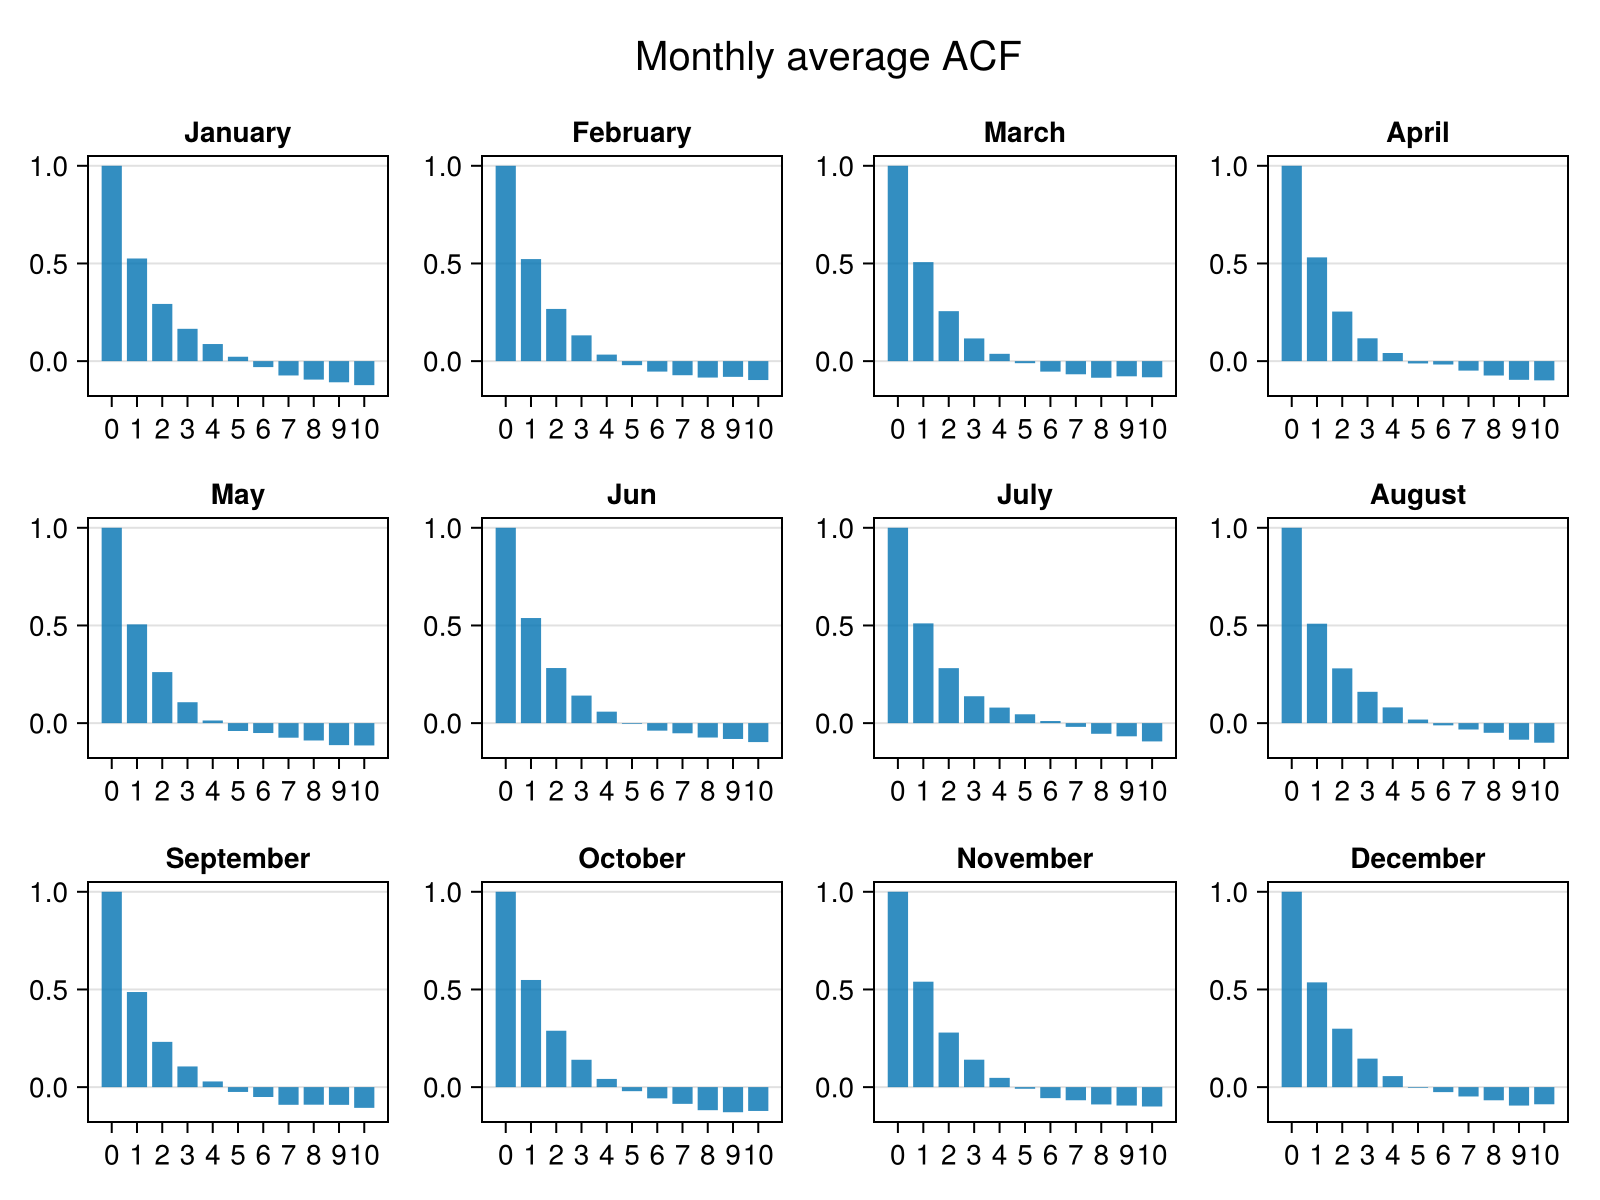

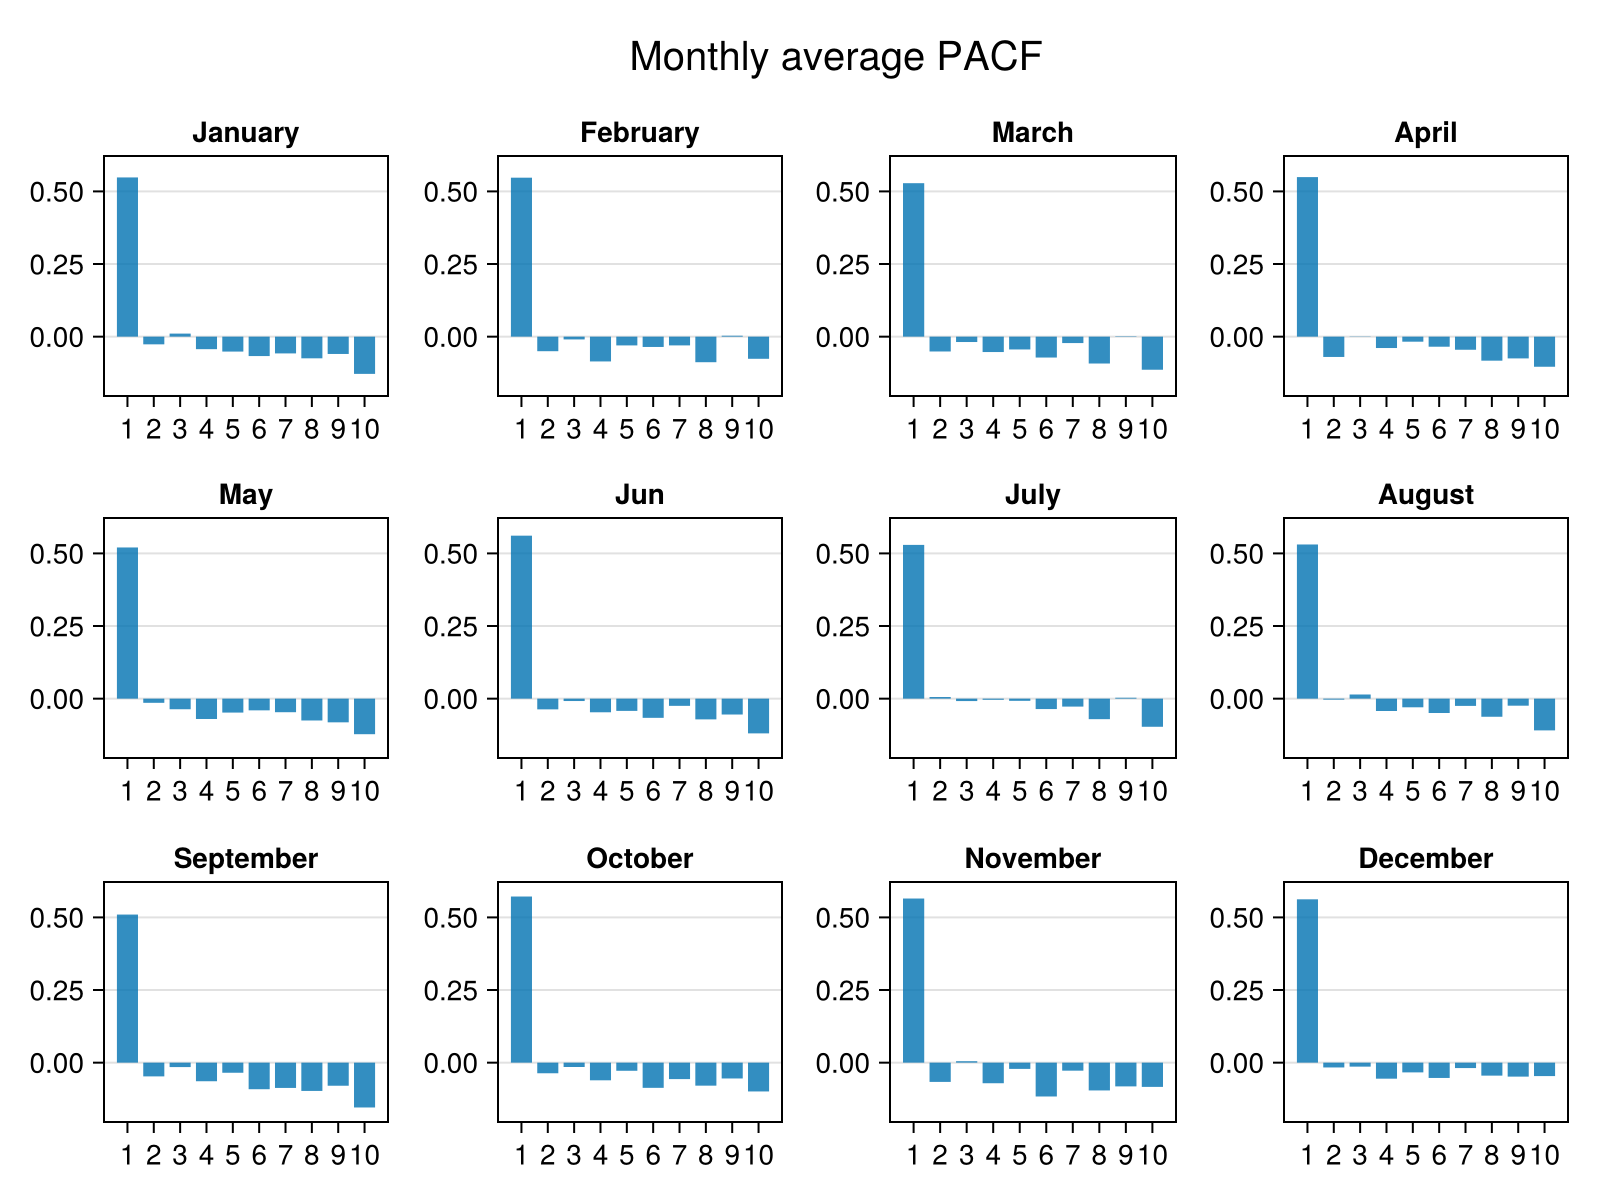

CairoMakie.Screen{IMAGE}


In [8]:
include("utils/ACF_PACF.jl")
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

For each month, it still looks like an AR(1) model

# Estimation AR(1)

## Estimation

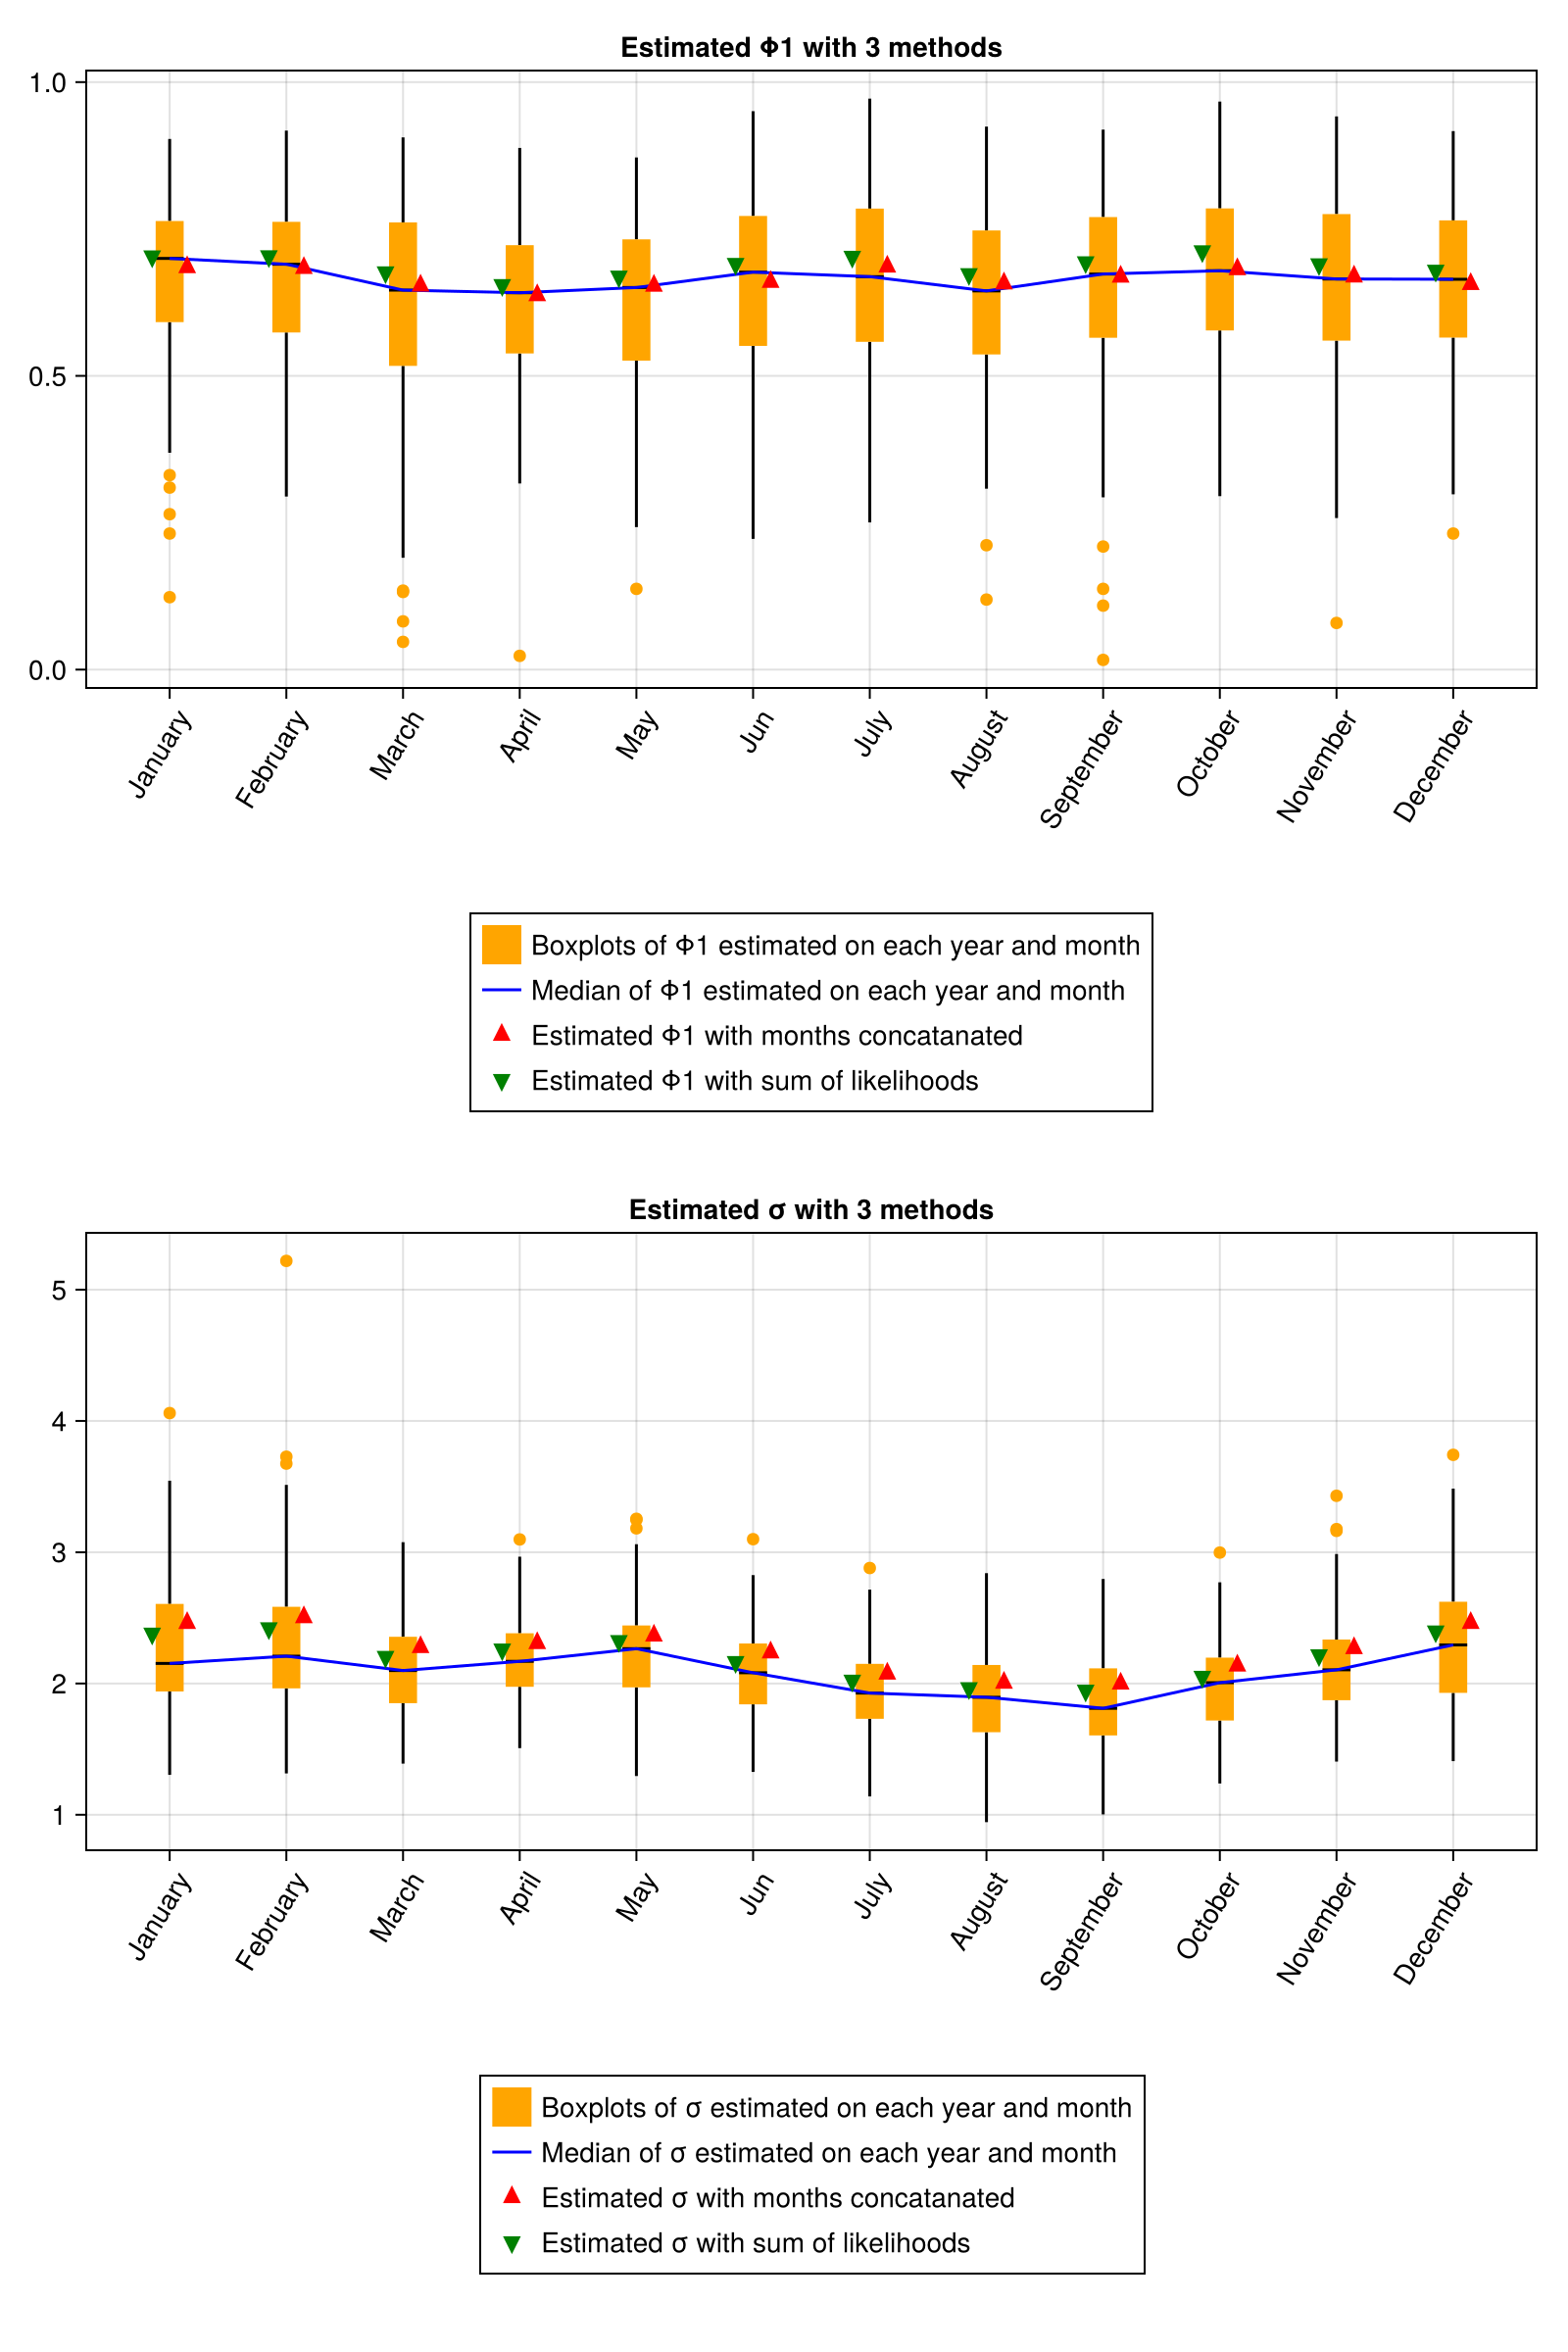

CairoMakie.Screen{IMAGE}


In [9]:
include(raw"utils\Estimation.jl")
Params, figure= AllEstimation(Monthly_temp, lineplot=true)
display(figure)

## Simulation

### With estimation on each month

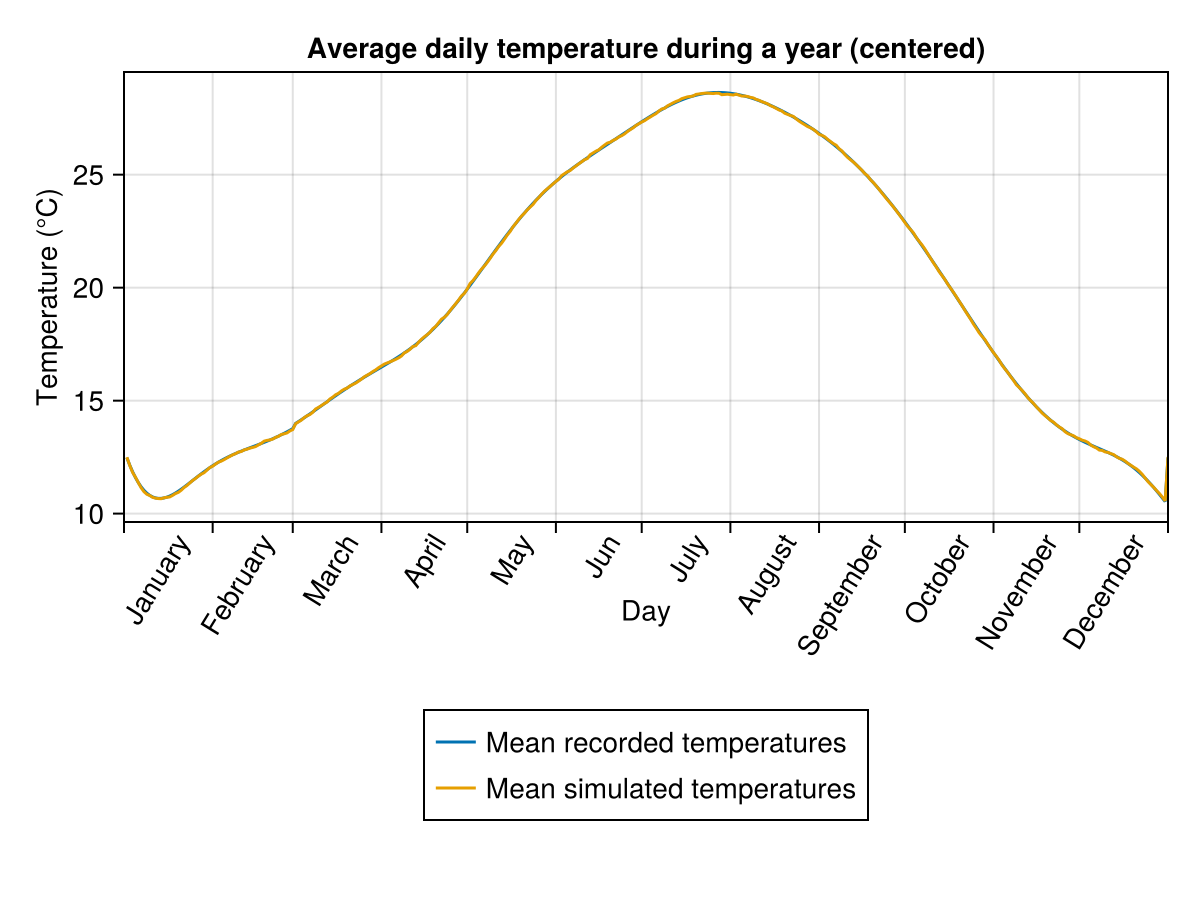

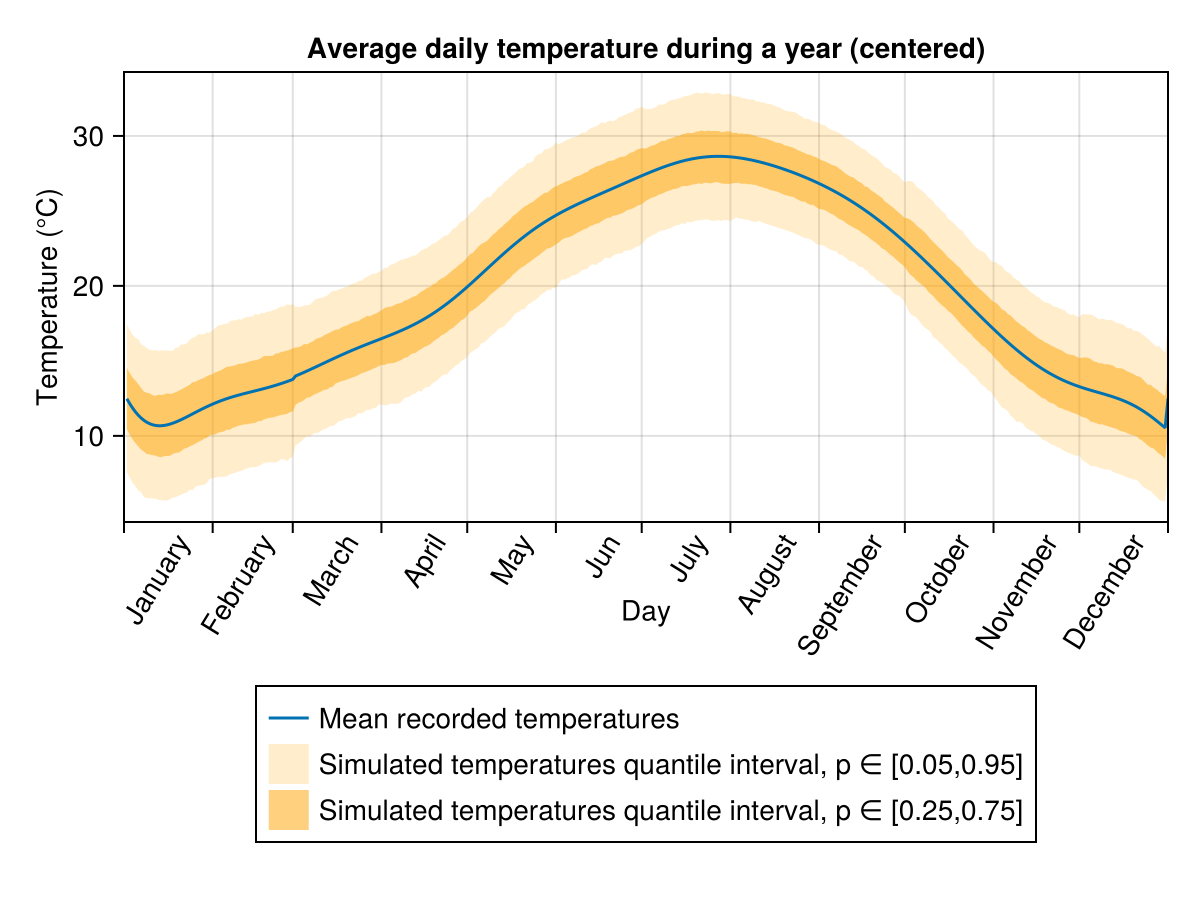

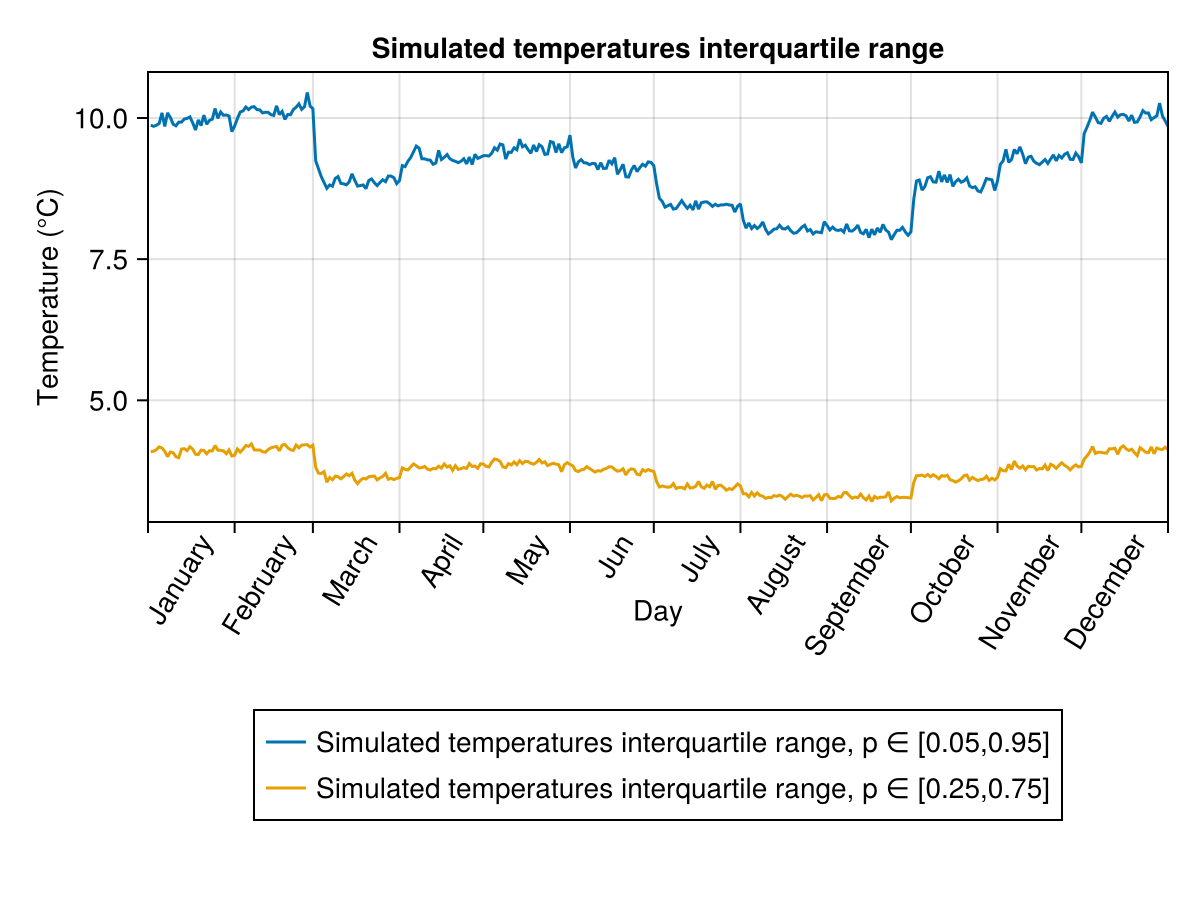

CairoMakie.Screen{IMAGE}


In [10]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"mean")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

We see clearly that interquartile range is shorter during summer and larger during winter.

### With months concatanation

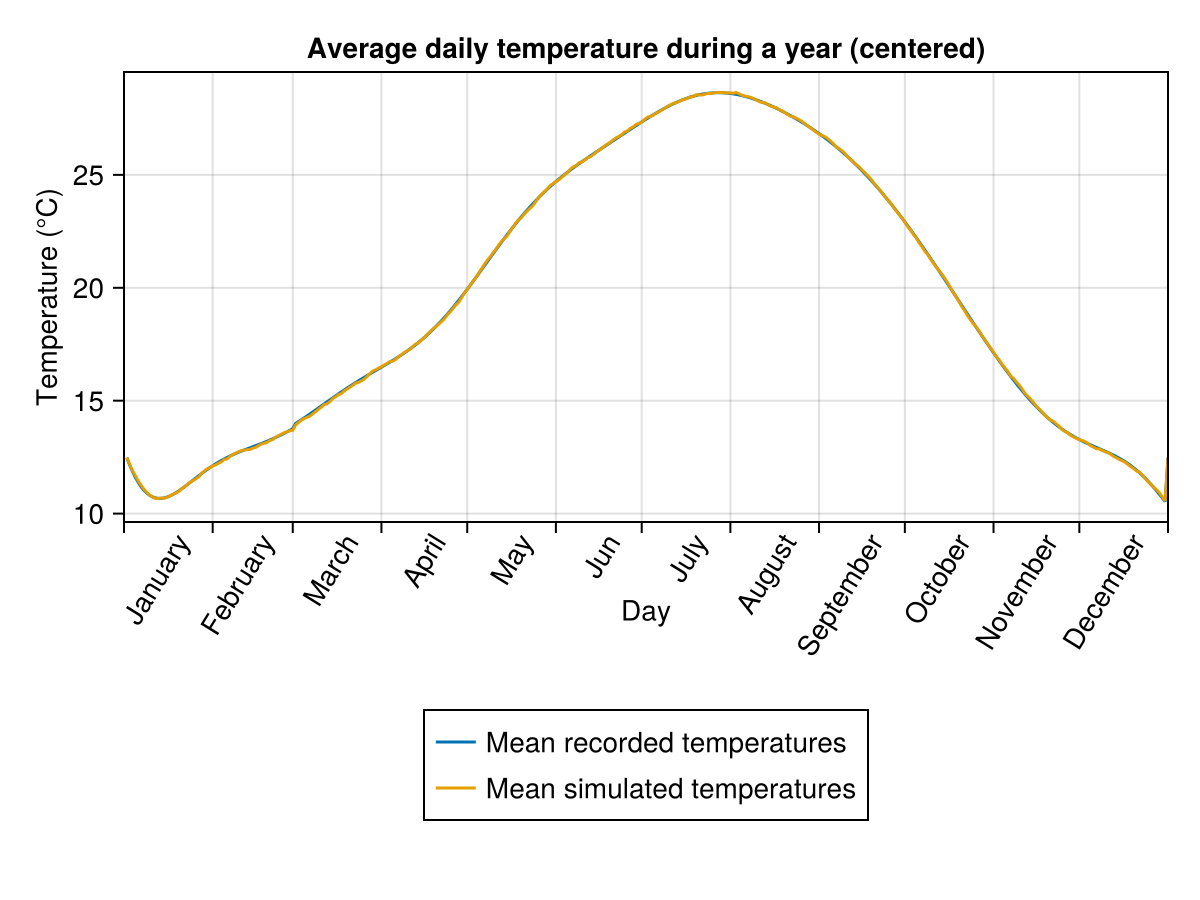

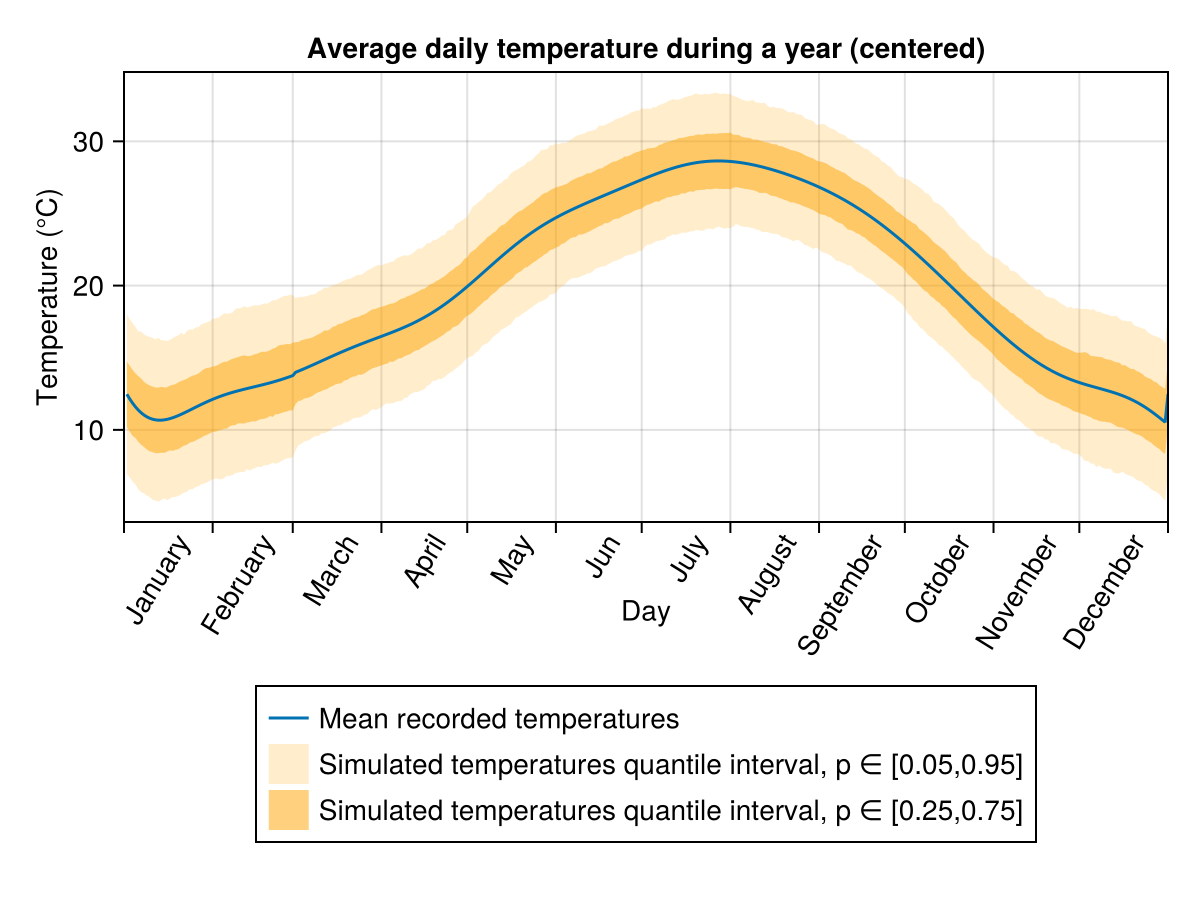

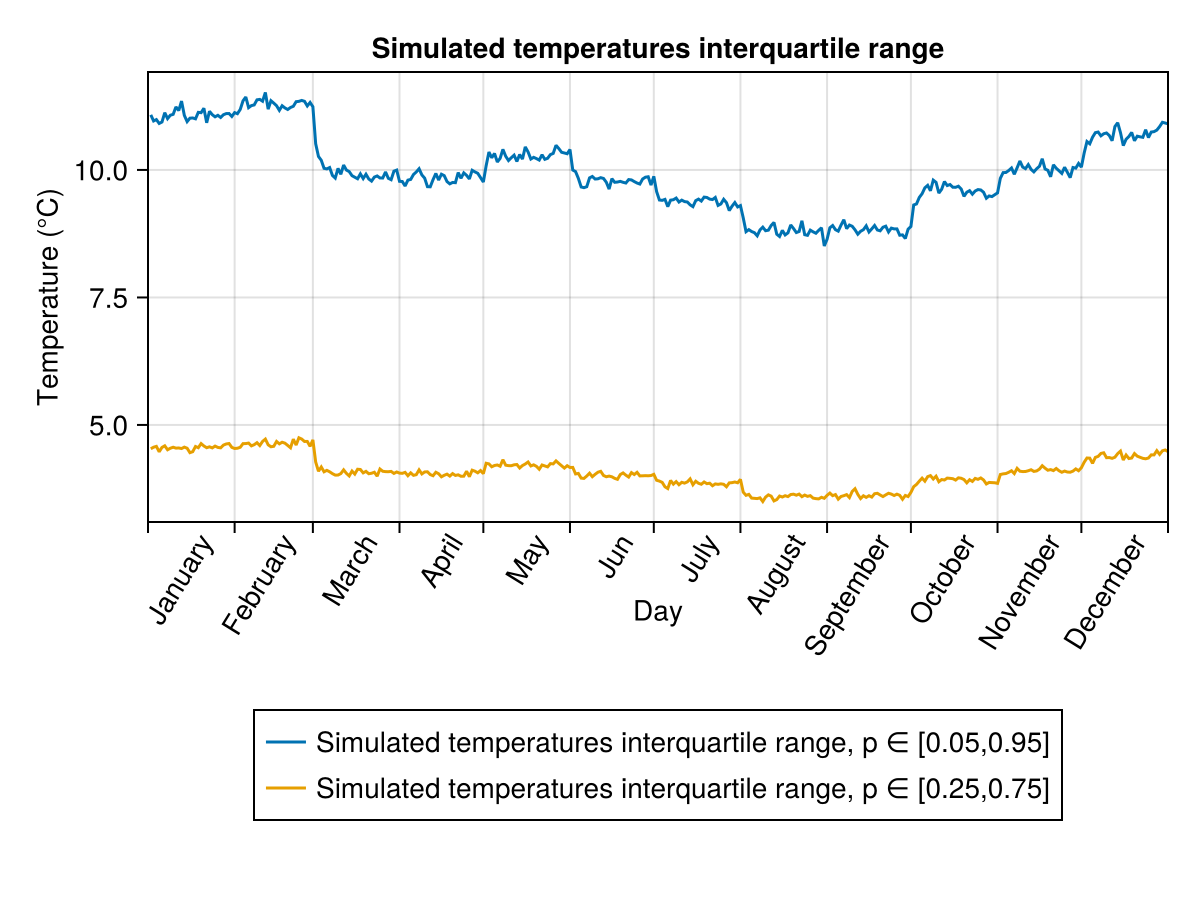

CairoMakie.Screen{IMAGE}


In [11]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"concat")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

### With sum of likelihoods

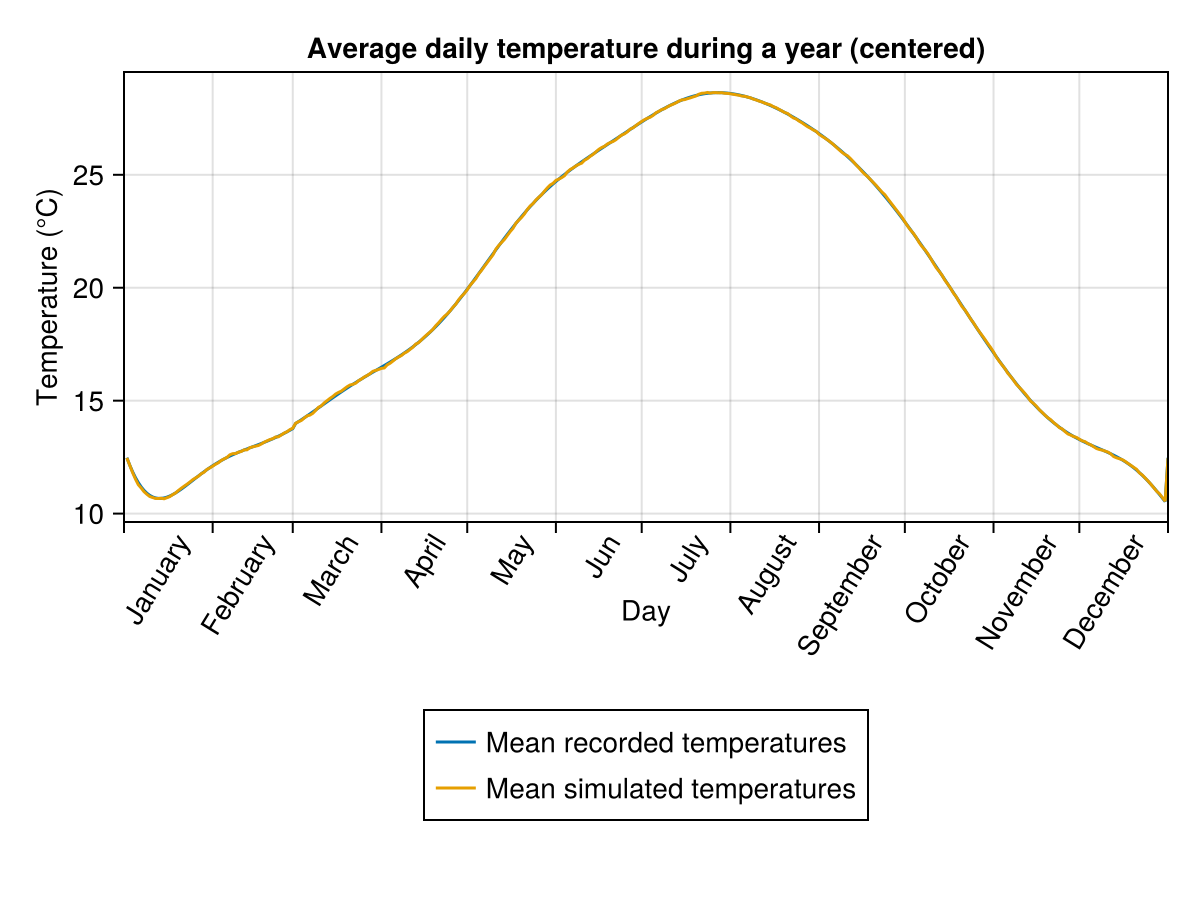

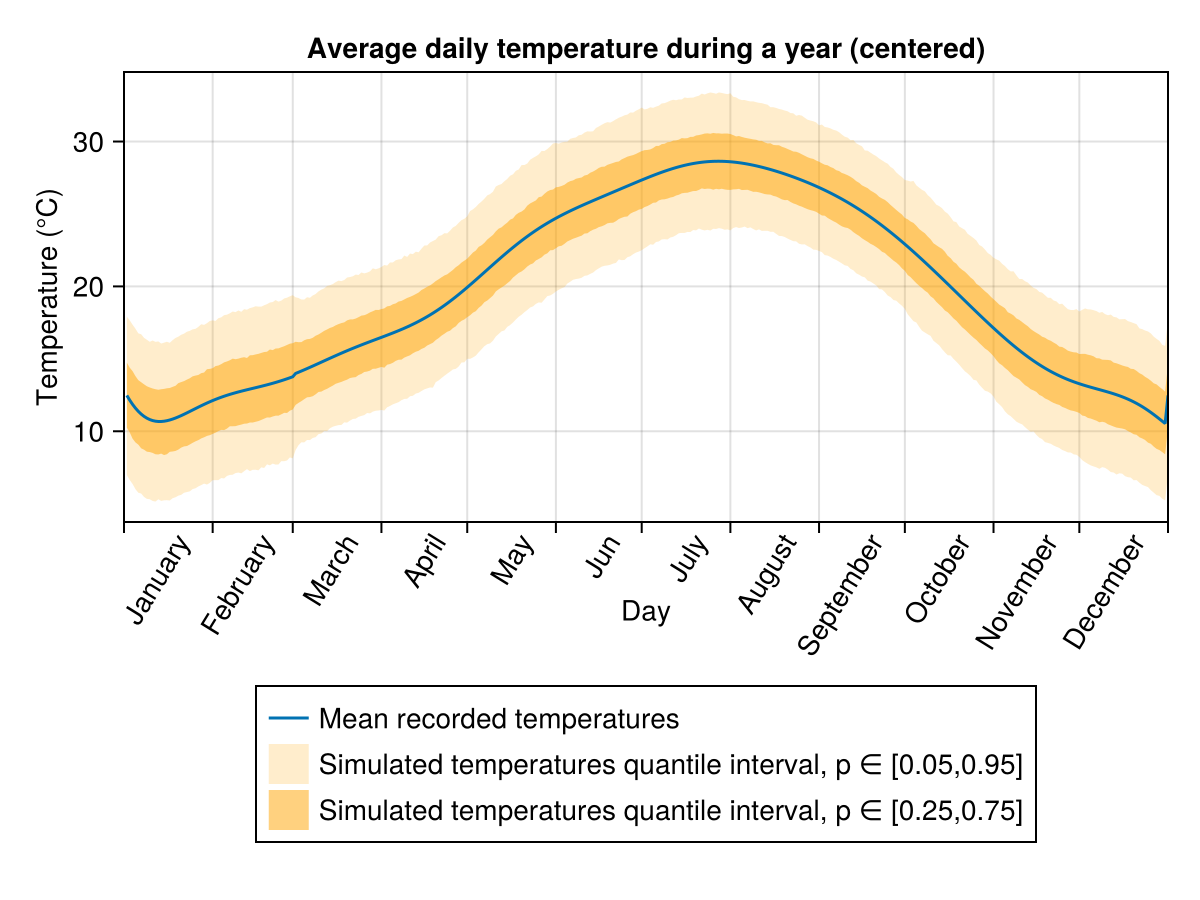

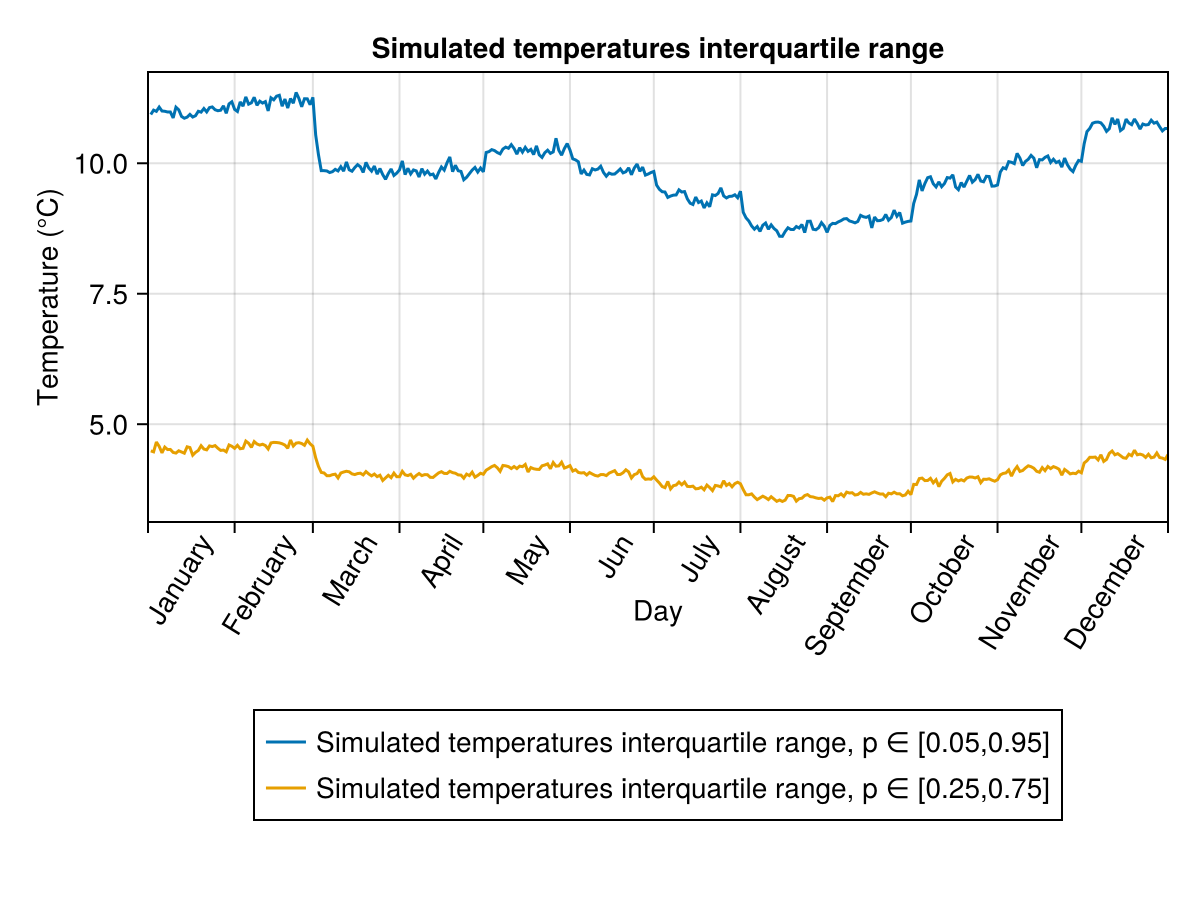

CairoMakie.Screen{IMAGE}


In [12]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"sumLL")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

# Estimation AR(2)

## Estimation

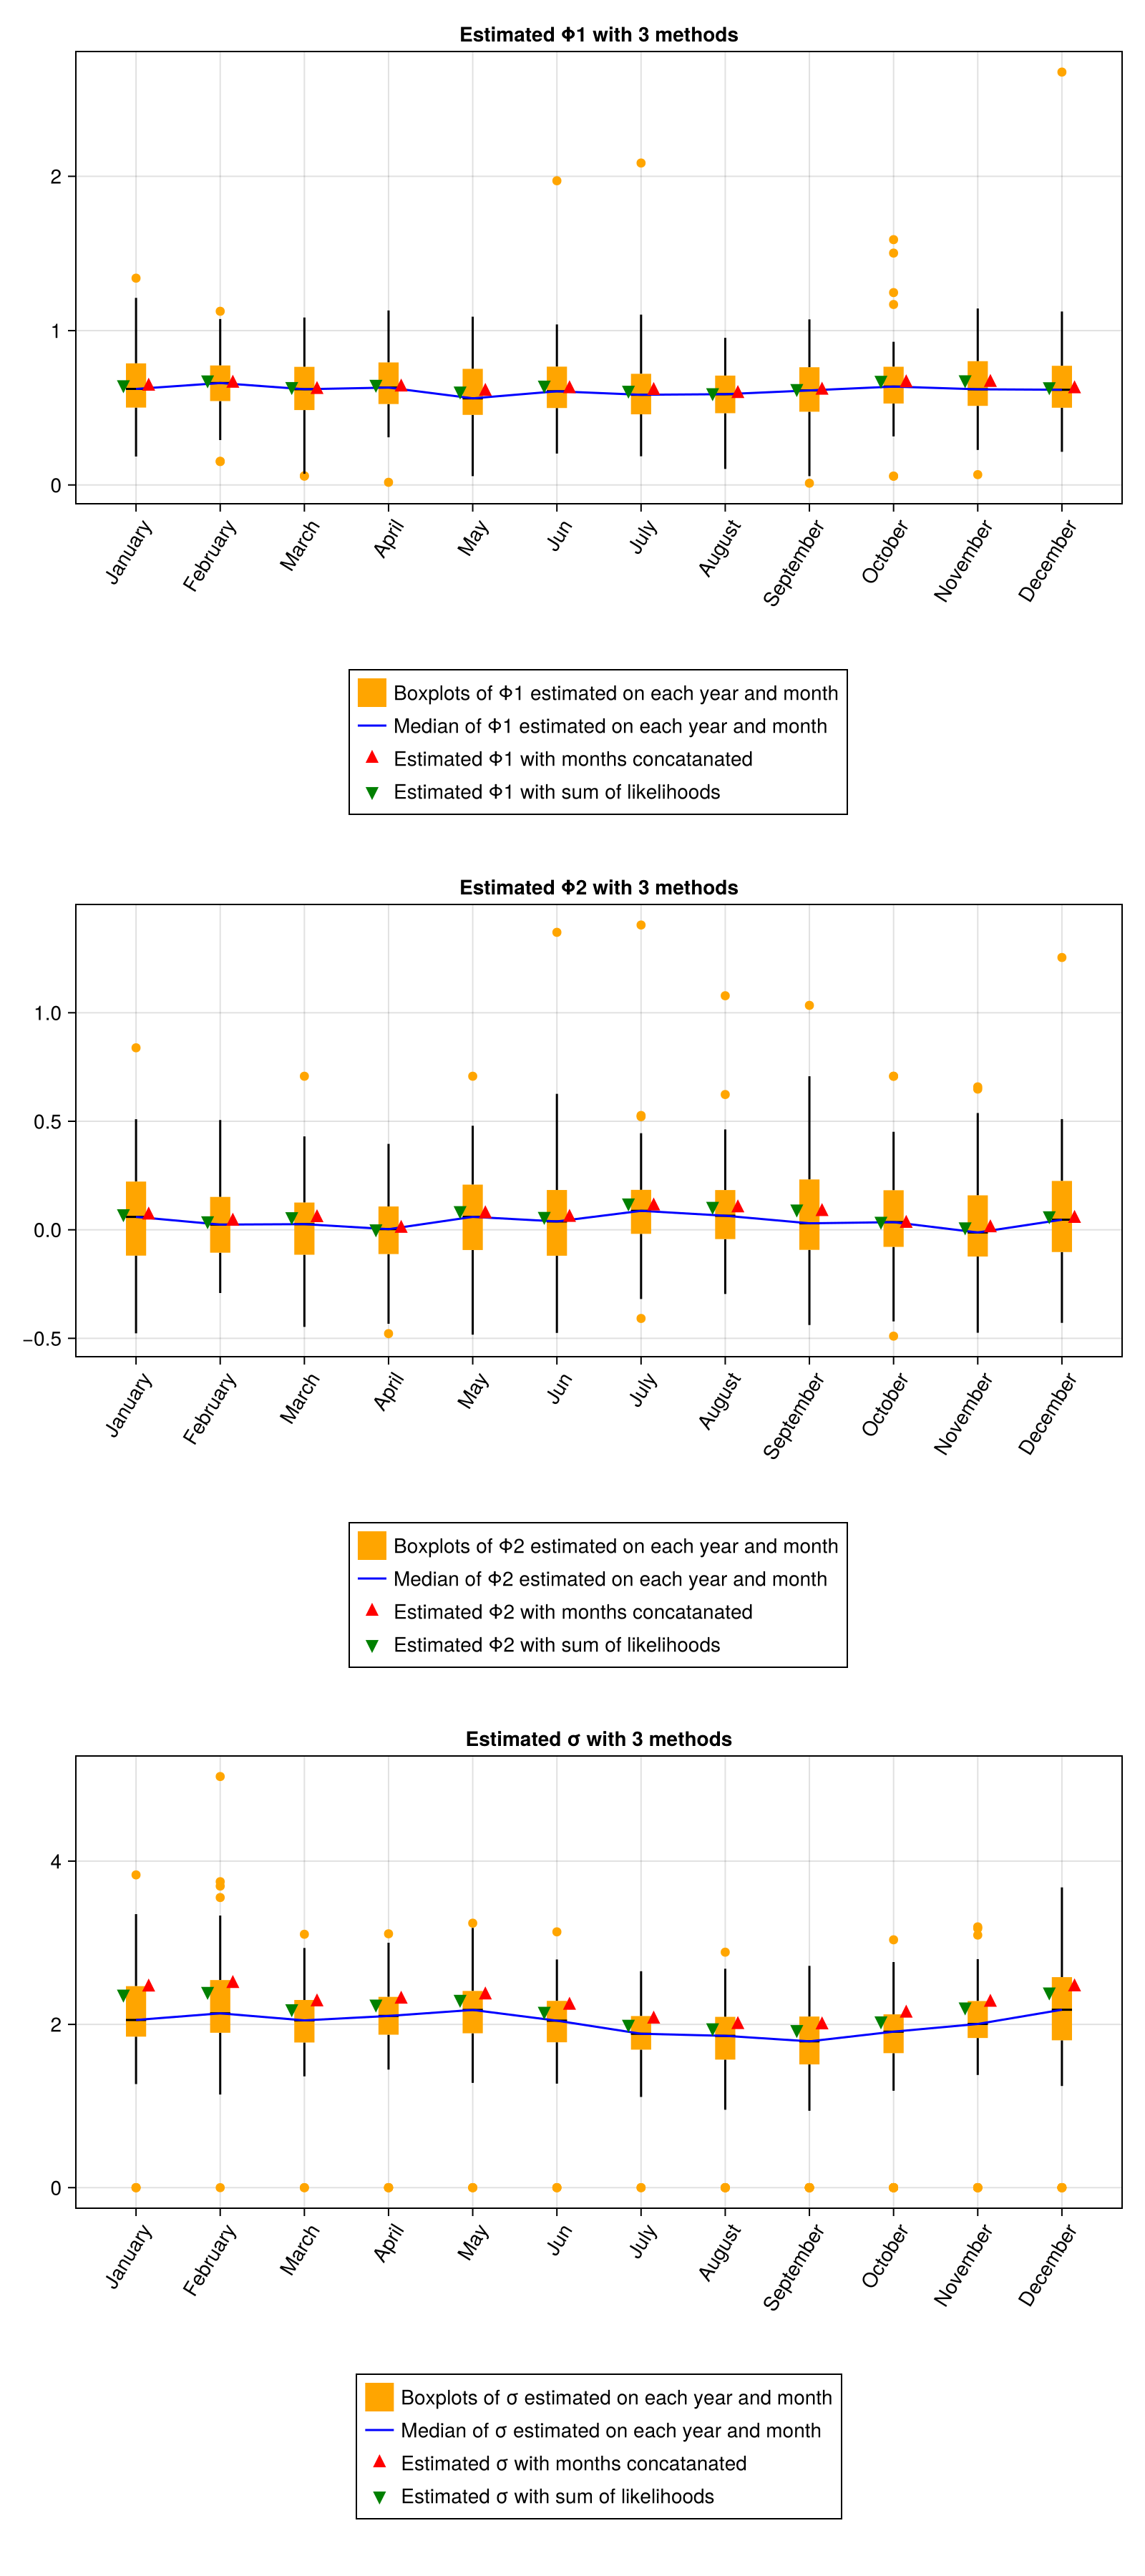

CairoMakie.Screen{IMAGE}


In [13]:
include(raw"utils\Estimation.jl")
Params, figure= AllEstimation(Monthly_temp, 2, lineplot=true)
display(figure)

## Simulation (WIP)

### With estimation on each month

In [19]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"mean")
sample_ = SimulateYears(Monthly_temp[1][1][1:2],series.DATE[2],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

DimensionMismatch: DimensionMismatch: a has size (366,), b has size (365,), mismatch at dim 1

We see clearly that interquartile range is shorter during summer and larger during winter.

### With months concatanation

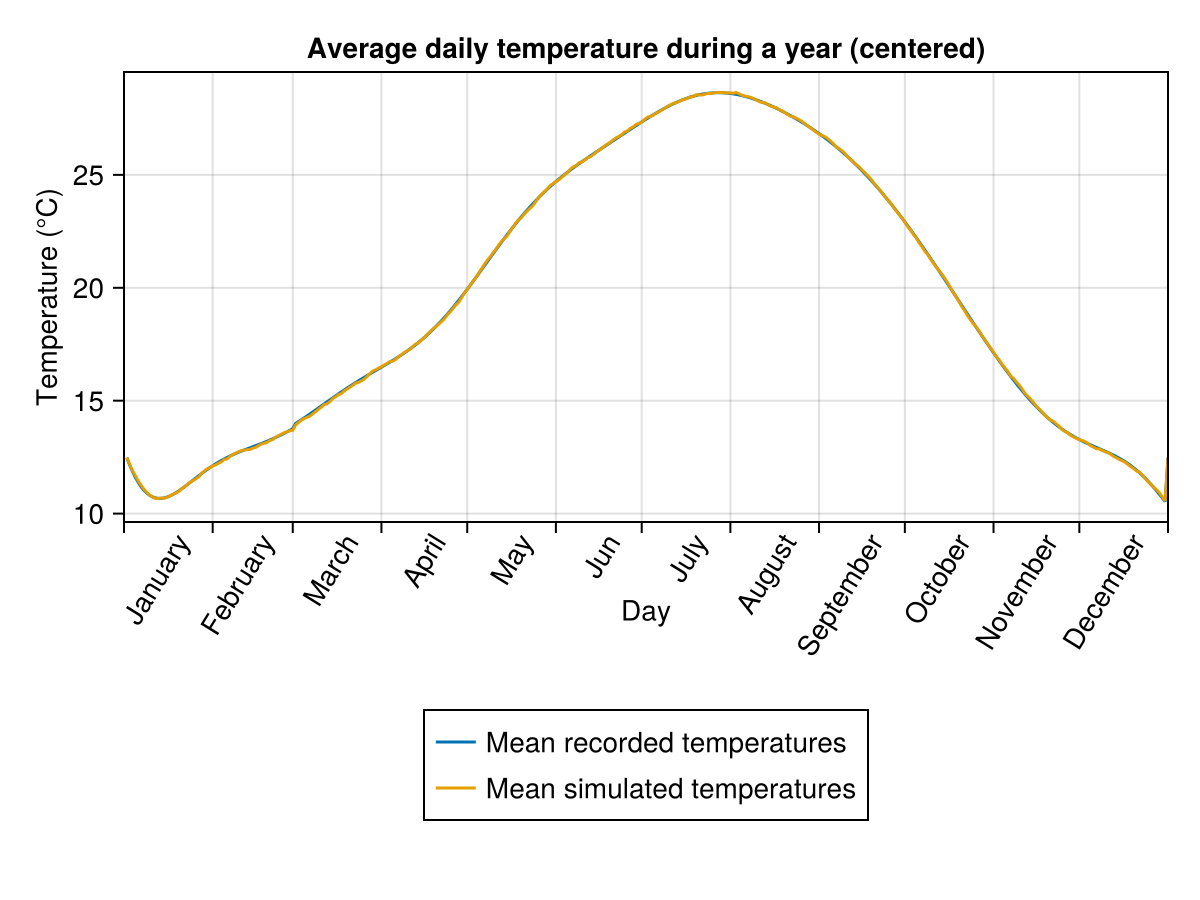

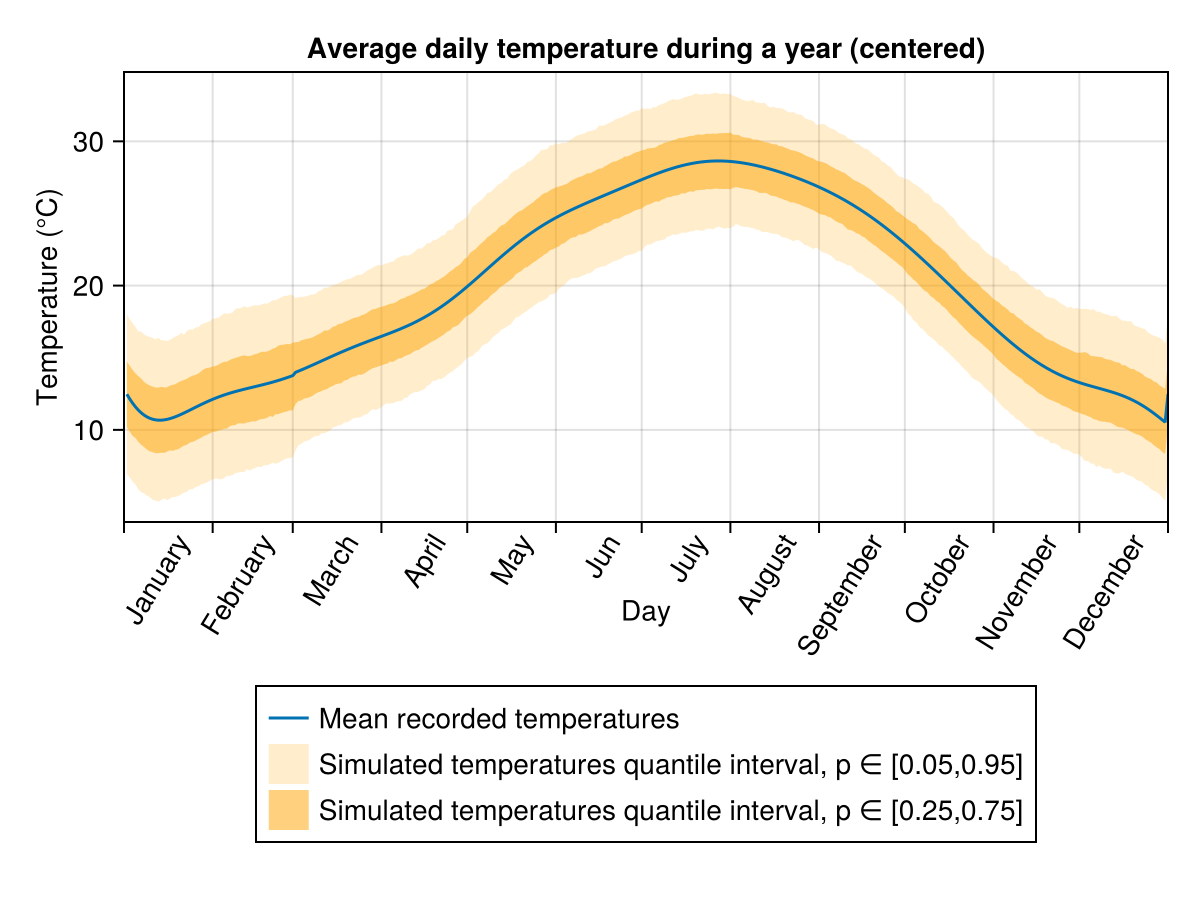

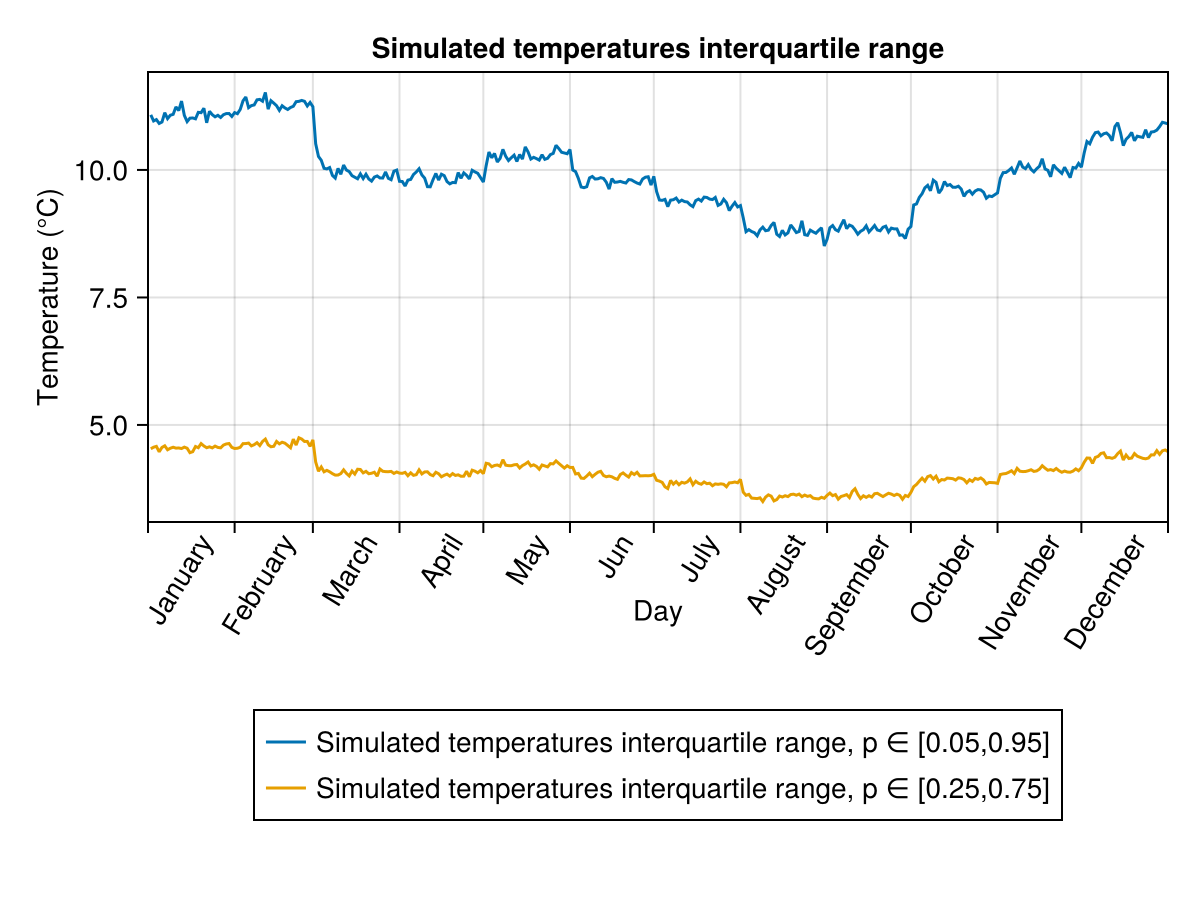

CairoMakie.Screen{IMAGE}


In [ ]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"concat")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

### With sum of likelihoods

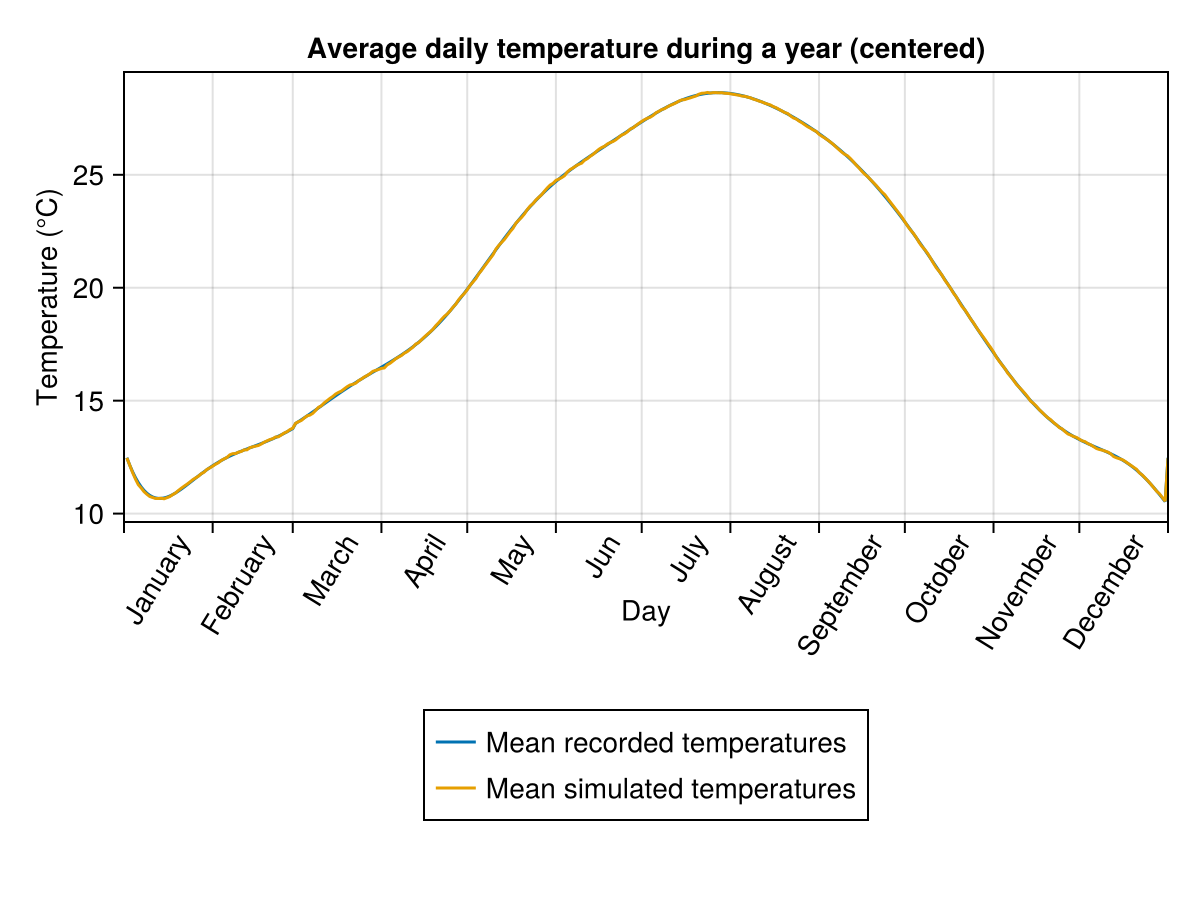

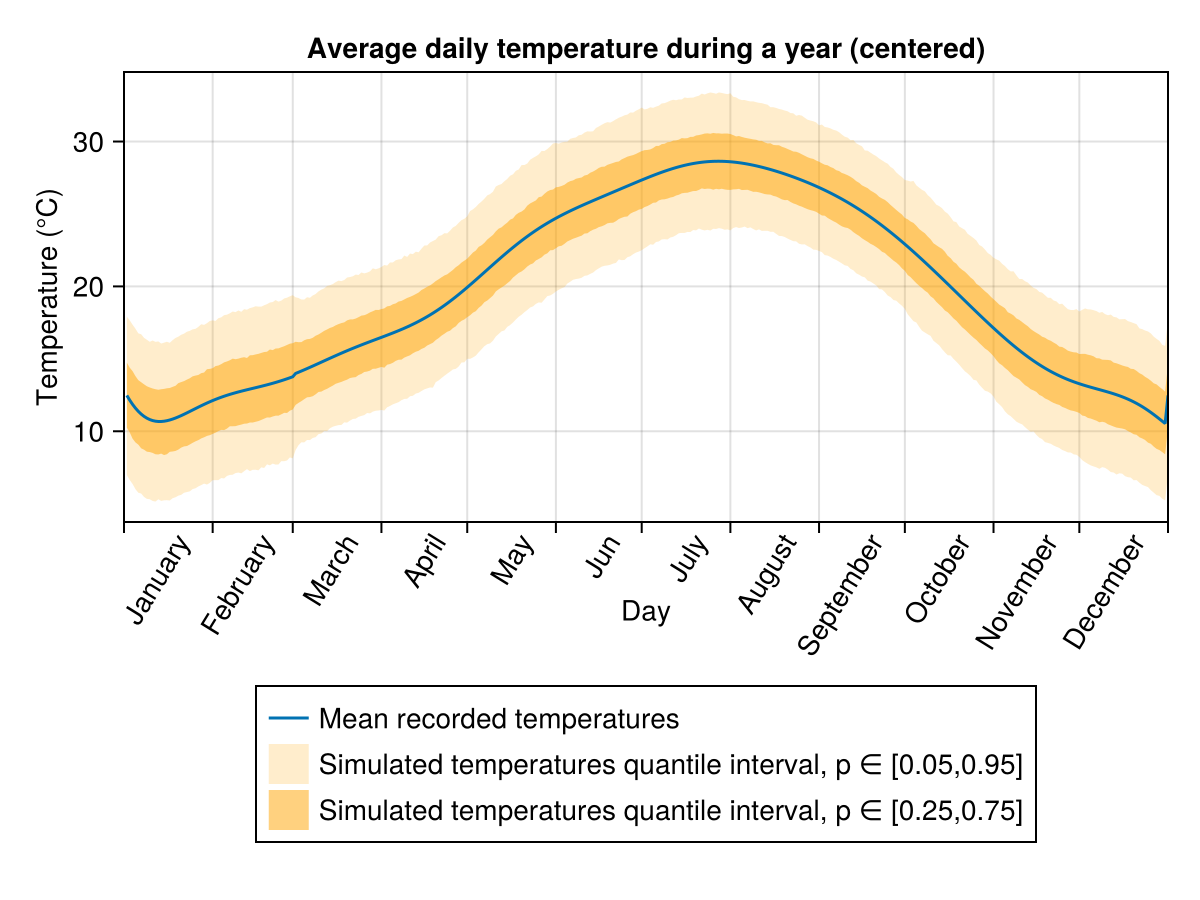

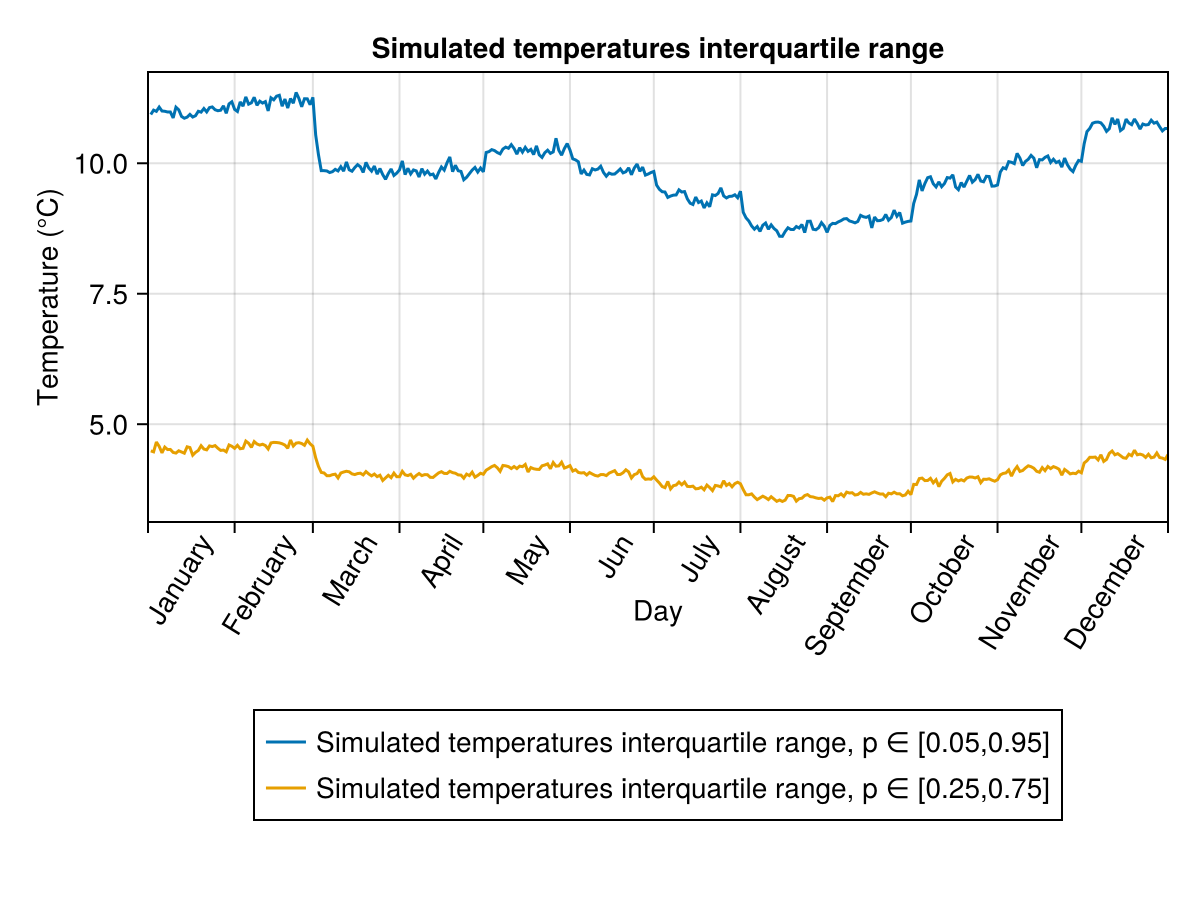

CairoMakie.Screen{IMAGE}


In [ ]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"sumLL")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))